In [1]:
import sys
sys.path.append('../../30_data_tools/')

In [49]:
import pandas as pd
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from pathlib import Path
import numpy as np
import sqlite3
import json
from collections import Counter
from datetime import datetime
import plotly.express as px

In [3]:
from helper import load_dotenv

In [4]:
from get_labelstudio_data import get_results_of_project

In [5]:
config = load_dotenv()

In [6]:
results = get_results_of_project(2)

In [7]:
pkl_files = list(config['GENERIC_INFORMATION_DATA_DIR'].glob('./*.pkl'))

In [8]:
frames = []
for pkl in pkl_files:
    f = pd.read_pickle(pkl)
    f.loc[
        :,
        'creation_date'
    ] = datetime.fromtimestamp(int(pkl.name.strip(pkl.suffix)))
    frames.append(f)
    
df = pd.concat([f for f in frames if 'ssim' in f.columns])
df.loc[
    :,
    'img_name'
] = df.apply(lambda row: row.basic_name.replace('$PLACEHOLDER$',row.method) + '.4c_600.jpg', axis=1)
df.loc[
    pd.isna(df.bbox) == False,
    'bbox'
] = df.loc[
    pd.isna(df.bbox) == False
].bbox.apply( lambda val: ",".join([str(v) for v in val]) )

df = pd.merge(
    df,
    pd.DataFrame(
        [
            (r['img_name'],r['rectanglelabels'][0],f"{r['value']['x']},{r['value']['y']},{r['value']['width']},{r['value']['height']}")
            for r in results
        ],
        columns=['img_name','label','bbox']
    ),
    how="left",
    on=["img_name","bbox"]
)

#df = df.drop_duplicates()

In [9]:
total_labels = df.label.value_counts()

total_labels

checked_no_moire    2110
unchecked_moire      482
checked_moire        353
Name: label, dtype: int64

In [10]:
total_labels.checked_moire / total_labels.sum()

0.1198641765704584

In [11]:
relevant_labels = df.loc[
    df.creation_date >= '2024-01-17'
].label.value_counts()

relevant_labels

checked_no_moire    1347
unchecked_moire      482
checked_moire        283
Name: label, dtype: int64

In [12]:
relevant_labels.checked_moire / relevant_labels.sum()

0.13399621212121213

In [13]:
df.loc[
    df.creation_date >= '2024-01-17'
].basic_name.unique().shape

(479,)

In [14]:
df.loc[
    df.creation_date == df.creation_date.max()
].shape

(1265, 47)

# Gruppiert nach Bild

In [15]:
df.loc[
    :,
    'job'
] = df.img_path.apply( lambda val: val.parent.parent.name )

In [16]:
grouped_by_job = df.loc[
    :,
    ['job','label','img_path']
].groupby(['job','label']).count().sort_values('img_path', ascending=False).unstack('label').fillna(0)

grouped_by_job.columns = [c[1] for c in grouped_by_job.columns]
grouped_by_job.loc[
    :,
    'moire_rate'
] = grouped_by_job.checked_moire / (grouped_by_job.checked_moire + grouped_by_job.checked_no_moire)

In [17]:
grouped_by_job.sort_values('moire_rate', ascending=False)

,checked_moire,checked_no_moire,unchecked_moire,moire_rate
job,,,,
612780,4.0,3.0,6.0,0.571429
149355,11.0,18.0,0.0,0.379310
606023,86.0,278.0,0.0,0.236264
613256,32.0,141.0,36.0,0.184971
613233,8.0,40.0,18.0,0.166667
148013,22.0,115.0,0.0,0.160584
611808,19.0,100.0,58.0,0.159664
24-01-02_randomPages,3.0,16.0,0.0,0.157895
606688,34.0,191.0,4.0,0.151111


# Auswertung nach Bildern

In [18]:
grouped_by_image = df.loc[
    :,
    ['image','label','img_path']
].groupby(['image','label']).count().sort_values('img_path', ascending=False).unstack('label').fillna(0)

grouped_by_image.columns = [c[1] for c in grouped_by_image.columns]
grouped_by_image.loc[
    :,
    'total_tiles'
] = grouped_by_image.checked_moire + grouped_by_image.checked_no_moire

grouped_by_image.loc[
    :,
    'moire_rate'
] = grouped_by_image.checked_moire / (grouped_by_image.checked_moire + grouped_by_image.checked_no_moire)

In [19]:
grouped_by_image.sort_values(['moire_rate','total_tiles'], ascending=[False,False]).iloc[:50]

,checked_moire,checked_no_moire,unchecked_moire,total_tiles,moire_rate
image,,,,,
HBZP_1_M_294.p1.4c,1.0,0.0,0.0,1.0,1.000000
tg39_67029_1_1_2022_130-189_Kapitel3_DA.p18.4c,6.0,3.0,0.0,9.0,0.666667
tg45_009-488_Interieur_GW2021-2022_HD.p314.4c,4.0,2.0,0.0,6.0,0.666667
tg46_UP_006_007_MRZ23_UPSUBHMRZ_SU_AS004_DE_DE_002.p1.4c,2.0,1.0,0.0,3.0,0.666667
tg46_024_025_JUL23_UPHK_CA_AS008_AT_DE_BASIS_BILD_002.p1.4c,5.0,3.0,0.0,8.0,0.625000
tg39_0072_20-1257_Part07_03_PGUE_GS_Premium_0321_DE.p1.4c,5.0,3.0,0.0,8.0,0.625000
tg39_0067_20-1257_Part07_03_PGUE_GS_Premium_0321_DE.p1.4c,5.0,3.0,0.0,8.0,0.625000
tg39_1000__147WW.DE.WX005.AT.141_10-12_39L_300.p2.4c,4.0,3.0,0.0,7.0,0.571429
tg39_0059_20-1257_Part06_02_PGUE_GS_Premium_0321_DE.p1.4c,4.0,3.0,0.0,7.0,0.571429


In [20]:
grouped_by_image.checked_no_moire.value_counts()

6.0     45
0.0     40
1.0     38
4.0     36
5.0     32
10.0    30
8.0     24
3.0     23
9.0     23
2.0     16
7.0     15
13.0     5
17.0     5
18.0     4
16.0     4
15.0     4
14.0     4
11.0     3
12.0     2
20.0     2
30.0     1
23.0     1
19.0     1
22.0     1
Name: checked_no_moire, dtype: int64

In [21]:
grouped_by_image.sort_values('moire_rate')

,checked_moire,checked_no_moire,unchecked_moire,total_tiles,moire_rate
image,,,,,
CJ134_018019.p2.4c,0.0,30.0,0.0,30.0,0.0
tg45_009-488_Interieur_GW2021-2022_HD.p282.4c,0.0,5.0,0.0,5.0,0.0
CJ134_132133.p1.4c,0.0,5.0,0.0,5.0,0.0
004_2023_017_0_108_0.p1.4c,0.0,5.0,0.0,5.0,0.0
tg39_Katalog AT 2023_24_print_Innen 63.p1.4c,0.0,4.0,0.0,4.0,0.0
...,...,...,...,...,...
tg42_20499 WWC+DE Katalog 11_2022_61.p1.4c,0.0,0.0,5.0,0.0,NaN
tg46_120_121_JUL23_UPHK_WA_AS001_AT_DE_BASIS_BILD_002.p1.4c,0.0,0.0,5.0,0.0,NaN
tg45_000_INM0323_DE_MEN_KERN_TAUSCH_kor1.p49.4c,0.0,0.0,5.0,0.0,NaN


# Auswertung nach Zeitstempel

In [44]:
grouped_by_timestamp = df.loc[
    :,
    ['creation_date','label','img_path']
].groupby(['creation_date','label']).count().sort_values('img_path', ascending=False).unstack('label').fillna(0)

grouped_by_timestamp.columns = [c[1] for c in grouped_by_timestamp.columns]
grouped_by_timestamp.loc[
    :,
    'total_tiles'
] = grouped_by_timestamp.checked_moire + grouped_by_timestamp.checked_no_moire

grouped_by_timestamp.loc[
    :,
    'moire_rate'
] = grouped_by_timestamp.checked_moire / (grouped_by_timestamp.checked_moire + grouped_by_timestamp.checked_no_moire)

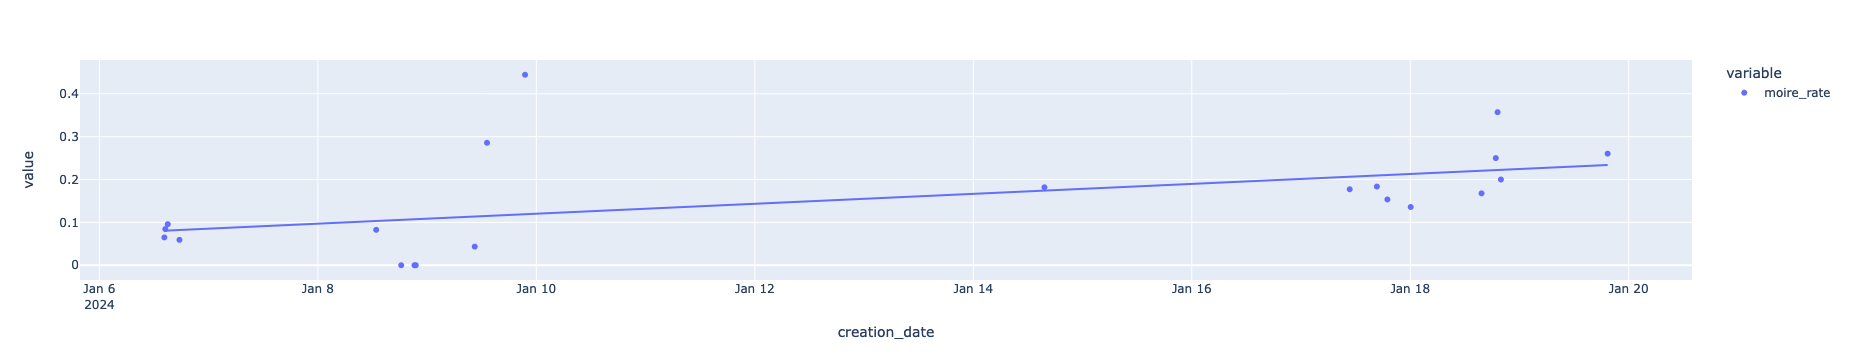

In [51]:
px.scatter(
    grouped_by_timestamp.sort_index().loc[
        :,
        'moire_rate'
    ],
    trendline="ols"
)

# Rest

In [40]:
df.loc[
    (df.bbox.apply(lambda val: int(val.split(',')[0])).between(270,330)) &
    (df.bbox.apply(lambda val: int(val.split(',')[1])).between(60,100)) &
    (df.bbox.apply(lambda val: int(val.split(',')[2])).between(1290,1310)) &
    (df.bbox.apply(lambda val: int(val.split(',')[3])).between(120,140))
].label.value_counts()

checked_no_moire    10
Name: label, dtype: int64

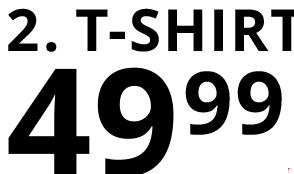

In [22]:
row = df.loc[90]

bbox = [int(v) for v in row.bbox.split(',')]
#img = Image.open( config['GENERIC_GENERATED_DATA_DIR'] / row.img_name )
img = Image.open( row.img_path )
img.crop((
    bbox[0],
    bbox[1],
    bbox[0]+bbox[2],
    bbox[1]+bbox[3]
))

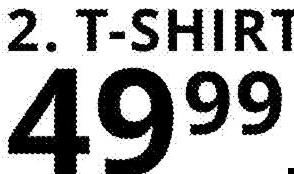

In [23]:
row = df.loc[90]

bbox = [int(v) for v in row.bbox.split(',')]
img = Image.open( config['GENERIC_GENERATED_DATA_DIR'] / row.img_name )
#img = Image.open( row.img_path )
img.crop((
    bbox[0],
    bbox[1],
    bbox[0]+bbox[2],
    bbox[1]+bbox[3]
))

In [24]:
df.loc[
    (pd.isna(df.label) == False) & (df.label != 'unchecked_moire'),
    ['creation_date','basic_name','img_name','bbox','label','ssim']
].sort_values('ssim')

,creation_date,basic_name,img_name,bbox,label,ssim
4035,2024-01-08 21:30:46,613233.tg46_UP_004_005_MRZ23_UPSUBHMRZ_SU_AS00...,613233.tg46_UP_004_005_MRZ23_UPSUBHMRZ_SU_AS00...,"2782,2000,1684,3262",checked_no_moire,0.458884
3991,2024-01-08 21:30:46,148013.tg39_67029_1_1_2022_130-189_Kapitel3_DA...,148013.tg39_67029_1_1_2022_130-189_Kapitel3_DA...,"3030,1278,150,312",checked_no_moire,0.680539
4131,2024-01-09 10:27:41,606023.tg39_0079_20-1257_Part07_03_PGUE_GS_Pre...,606023.tg39_0079_20-1257_Part07_03_PGUE_GS_Pre...,"2814,2004,240,246",checked_no_moire,0.750932
468,2024-01-17 10:41:38,615311.CJ134_174175.p1.$PLACEHOLDER$.1,615311.CJ134_174175.p1.soft_light.1.4c_600.jpg,"4614,3918,144,648",checked_no_moire,0.754663
279,2024-01-06 14:16:10,615311.CJ134_192193.p2.$PLACEHOLDER$.1,615311.CJ134_192193.p2.soft_light.1.4c_600.jpg,"156,1446,618,624",checked_moire,0.754748
...,...,...,...,...,...,...
2652,2024-01-08 18:18:54,508980.0154_O086.p1.$PLACEHOLDER$.1,508980.0154_O086.p1.soft_light.1.4c_600.jpg,"2244,468,390,120",checked_no_moire,1.000000
4871,2024-01-06 14:28:28,613476.693102_Top_03_BK_FS23_092_093_BFL_MM.p1...,613476.693102_Top_03_BK_FS23_092_093_BFL_MM.p1...,"0,6840,348,336",checked_no_moire,1.000000
59,2024-01-08 12:48:12,606023.tg39_0082_20-1257_Part07_03_PGUE_GS_Pre...,606023.tg39_0082_20-1257_Part07_03_PGUE_GS_Pre...,"204,0,4944,120",checked_no_moire,1.000000
4393,2024-01-08 21:13:20,508980.0090_O086.p1.$PLACEHOLDER$.1,508980.0090_O086.p1.soft_light.1.4c_600.jpg,"696,216,606,378",checked_no_moire,1.000000


In [25]:
0 / 0

ZeroDivisionError: division by zero